In [1]:
import numpy as np
import cupy as cp
import sys
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from types import SimpleNamespace
import h5py
import dxchange
import warnings
import pandas as pd
warnings.filterwarnings("ignore", message=f".*peer.*")

sys.path.insert(0, '..')
from utils import *
from rec import Rec

astropy module not found
olefile module not found


In [2]:
cf = 2
ntheta = 720
path = f'/data/vnikitin/ESRF/ID16A/20240924_rec_ca/data/'
iter = 1024
with  h5py.File(f'{path}/data_atomium.h5','r') as fid:
    code = fid[f'/exchange/code{iter}'][:].astype('complex64')
    q = fid[f'/exchange/prb{iter}'][:].astype('complex64')    
    shifts_cor = fid[f'/exchange/shifts_cor{iter}'][::7200//ntheta].astype('float32')
    shifts_code = fid[f'/exchange/shifts_code{iter}'][::7200//ntheta].astype('float32')    
    z1 = fid['/exchange/z1'][0]
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]
    focusdetectordistance = fid['/exchange/focusdetectordistance'][0]
    energy = fid['/exchange/energy'][0]

with  h5py.File(f'{path}/data_ca.h5','r') as fid:
    z1c = fid['/exchange/z1'][0] 

q = q[q.shape[0]//2-q.shape[0]//2**cf//2:q.shape[0]//2+q.shape[0]//2**cf//2,
        q.shape[1]//2-q.shape[1]//2**cf//2:q.shape[1]//2+q.shape[1]//2**cf//2]
code = code[code.shape[0]//2-code.shape[0]//2**cf//2:code.shape[0]//2+code.shape[0]//2**cf//2,
        code.shape[1]//2-code.shape[1]//2**cf//2:code.shape[1]//2+code.shape[1]//2**cf//2]
    
shifts_cor/=2**cf
shifts_code/=2**cf

In [3]:
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification) # object voxel size
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)
show = True

In [4]:
args = SimpleNamespace()
args.ngpus = 4

args.n = 2048//2**cf
args.ntheta = ntheta
args.ncode = 8192*args.n//2048
args.pad = 32
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.nchunk = 32

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec
args.rotation_axis=756*args.n/1024-args.n//4+args.pad
args.show = True
args.theta = np.linspace(0,np.pi,ntheta).astype('float32')
# create class
cl_rec = Rec(args)
print(voxelsize,distance,distancec)

7.0005117e-09 0.0029432012 -0.0034402816


In [5]:
q = np.pad(q,((args.pad,args.pad),(args.pad,args.pad)),'symmetric')

# introdcue some floating part in shifts code:

In [6]:
np.random.seed(10)
shifts_code+=2*(np.random.random([ntheta,2])-0.5).astype('float32')

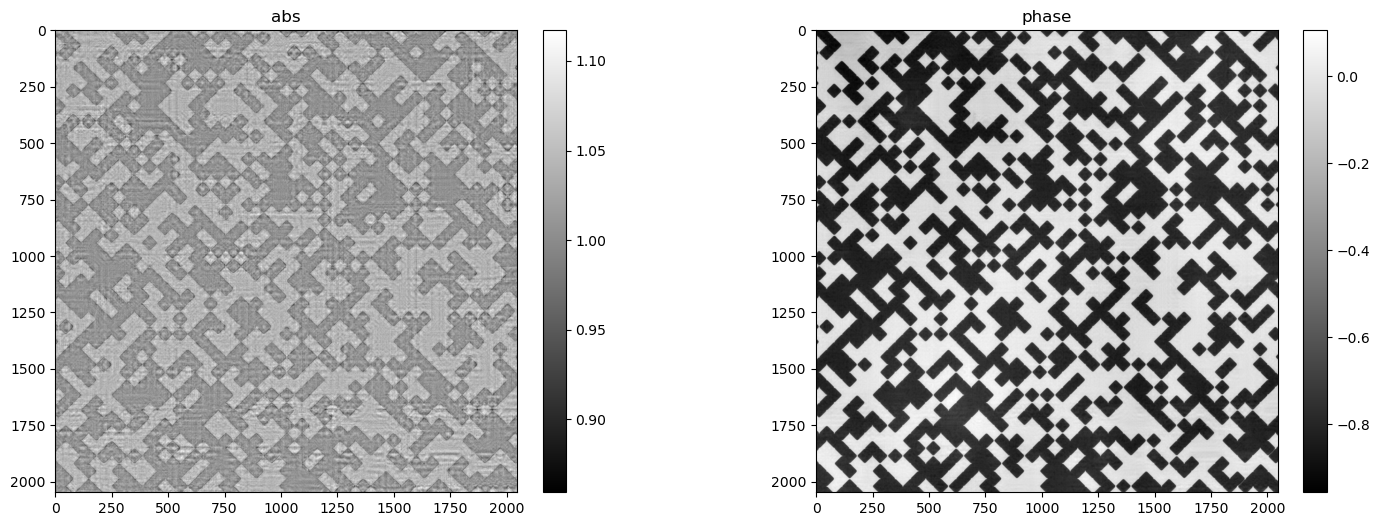

In [7]:
mshow_polar(code,show)

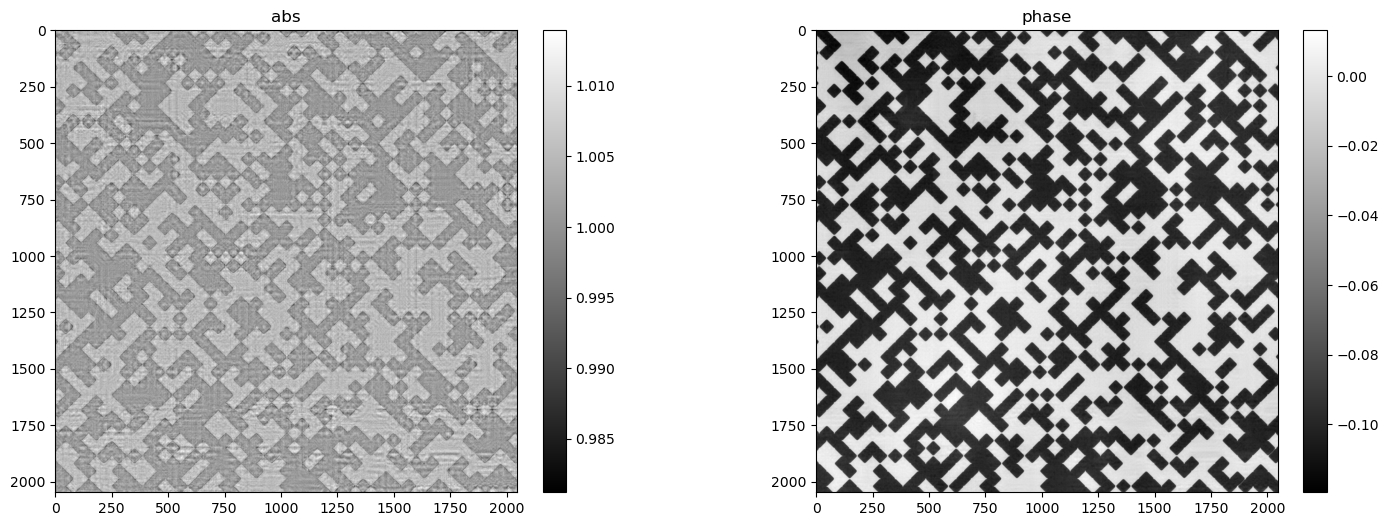

In [8]:
# code = np.exp(np.log(np.abs(code))/8+1j*np.angle(code)/8)
# # code = code.real+1j*code.imag/2
# code=code
# mshow_polar(code,show)

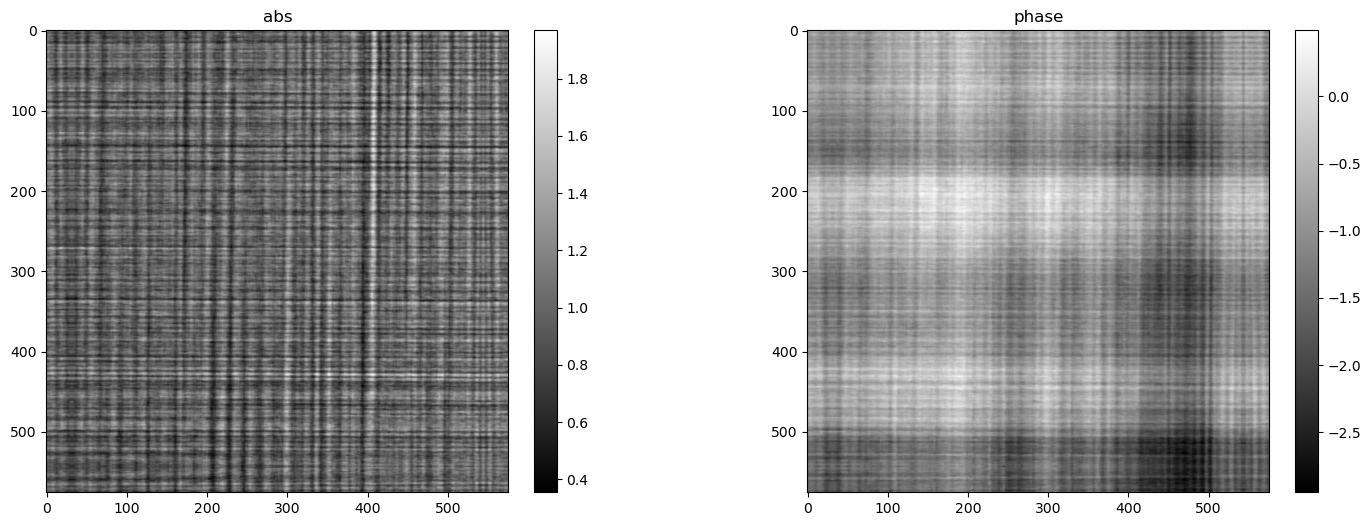

In [9]:
u = 4e3*np.load(f'/data/vnikitin/syn_3d_ald/u{args.n//2}.npy').astype('complex64')
u = u.real/7+1j*u.imag*5

pp = (args.n-u.shape[-1])//2+args.pad
u = np.pad(u,((pp,pp),(pp,pp),(pp,pp)),'edge')
# mshow_complex(u[args.npsi//2],True)
shifts_code = np.array(shifts_code) #
shifts_cor = np.array(shifts_cor)
code = np.array(code)
q = np.array(q)

ri = shifts_code.astype('int32')
r = shifts_code-shifts_code.astype('int32')
rpsi = shifts_cor
mshow_polar(q,show)

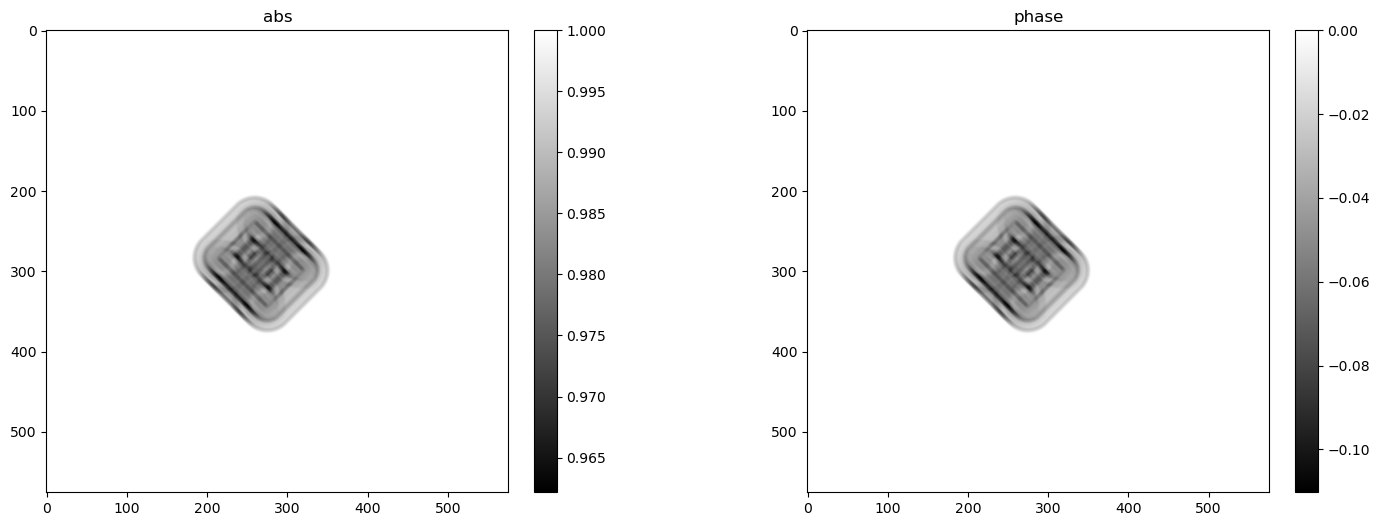

In [10]:
psi = cl_rec.expR(cl_rec.Spsi(cl_rec.R(u),rpsi))

mshow_polar(psi[0],True)

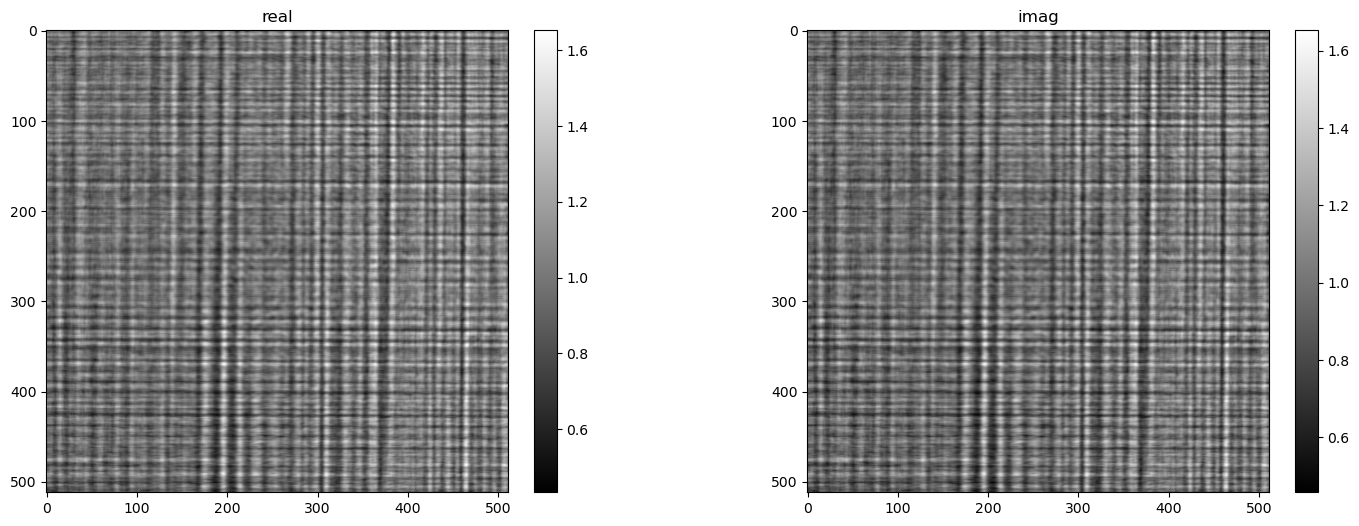

In [11]:
data = np.abs(cl_rec.D(cl_rec.Dc(q*cl_rec.S(ri,r,code))*cl_rec.expR(cl_rec.Spsi(cl_rec.R(u),rpsi))))
mshow_complex(data[0]+1j*data[ntheta//2],show)

In [12]:

# mshow_polar(code[:args.n//4,:args.n//4],show)
# v = np.arange(-code.shape[-1]//2,code.shape[-1]//2)/q.shape[-1]
# [vx,vy] = np.meshgrid(v,v)
# v=np.exp(-2*(vx**2+vy**2))
# code = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(code)))
# code = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(code*v)))
# code = code.astype('complex64')
# mshow_polar(code[:args.n//4,:args.n//4],show)


In [13]:
# use prb and code from earlier iter

In [14]:
# iter = 4096 # 2048
# with  h5py.File(f'{path}/data_atomium.h5','r') as fid:
#     code = fid[f'/exchange/code{iter}'][:].astype('complex64')
#     q = fid[f'/exchange/prb{iter}'][:].astype('complex64')    
#     shifts_cor = fid[f'/exchange/shifts_cor{iter}'][::7200//ntheta].astype('float32')
#     shifts_code = fid[f'/exchange/shifts_code{iter}'][::7200//ntheta].astype('float32')    
# q = q[q.shape[0]//2-q.shape[0]//2**cf//2:q.shape[0]//2+q.shape[0]//2**cf//2,
#         q.shape[1]//2-q.shape[1]//2**cf//2:q.shape[1]//2+q.shape[1]//2**cf//2]
# code = code[code.shape[0]//2-code.shape[0]//2**cf//2:code.shape[0]//2+code.shape[0]//2**cf//2,
#         code.shape[1]//2-code.shape[1]//2**cf//2:code.shape[1]//2+code.shape[1]//2**cf//2]

# q = np.pad(q,((args.pad,args.pad),(args.pad,args.pad)),'symmetric')    
# shifts_cor/=2**cf
# shifts_code/=2**cf
# print(q.shape,code.shape)
# mshow_polar(q,show)

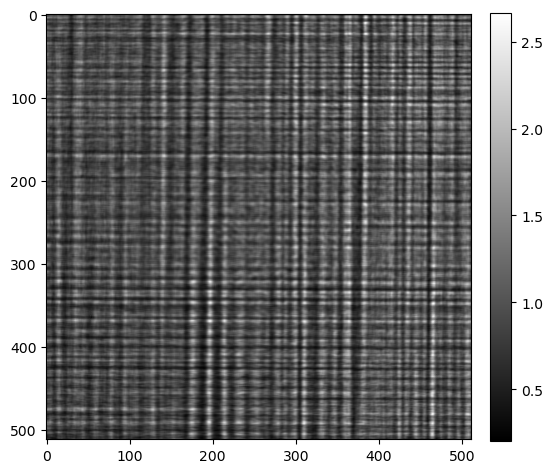

In [15]:
ref = np.abs(cl_rec.D(cl_rec.Dc(q[np.newaxis])))**2

# data = np.abs(cl_rec.D(cl_rec.Dc(q*cl_rec.S(ri,r,code))*cl_rec.expR(cl_rec.Spsi(cl_rec.R(u),rpsi))))
# mshow_complex(data[0]+1j*data[ntheta//2],show)

cpad = args.pad*3//2
q_init = cl_rec.DcT(cl_rec.DT(np.sqrt(ref)))[0,cpad:-cpad,cpad:-cpad]
q_init = np.pad(q_init,((cpad,cpad),(cpad,cpad)),'symmetric')
mshow(ref[0],args.show)

0) err=1.06943e+06


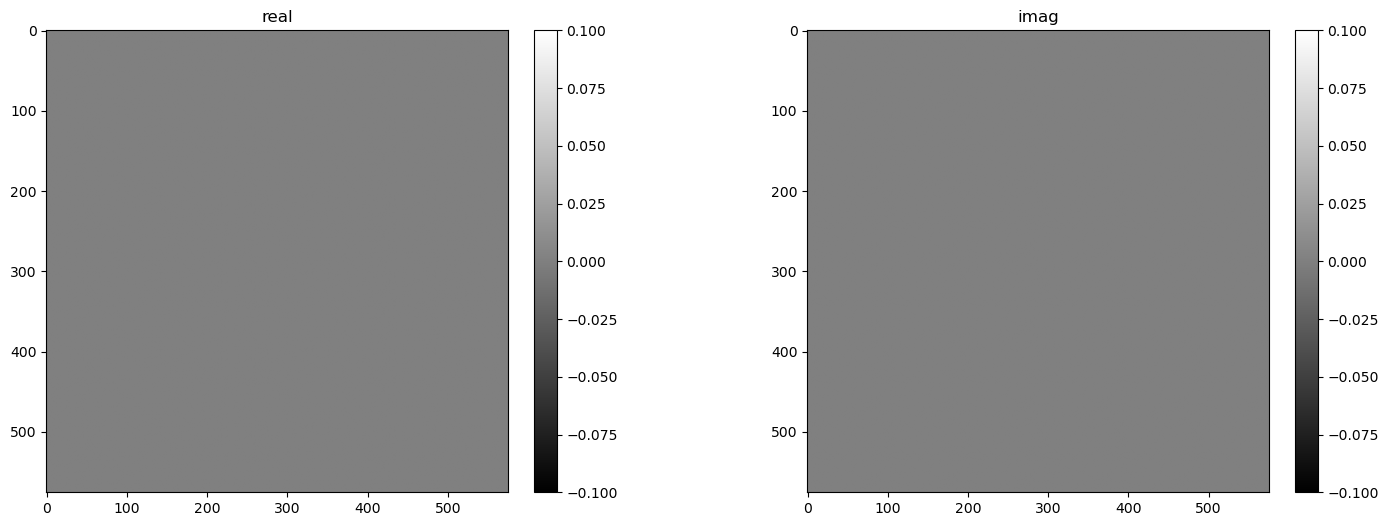

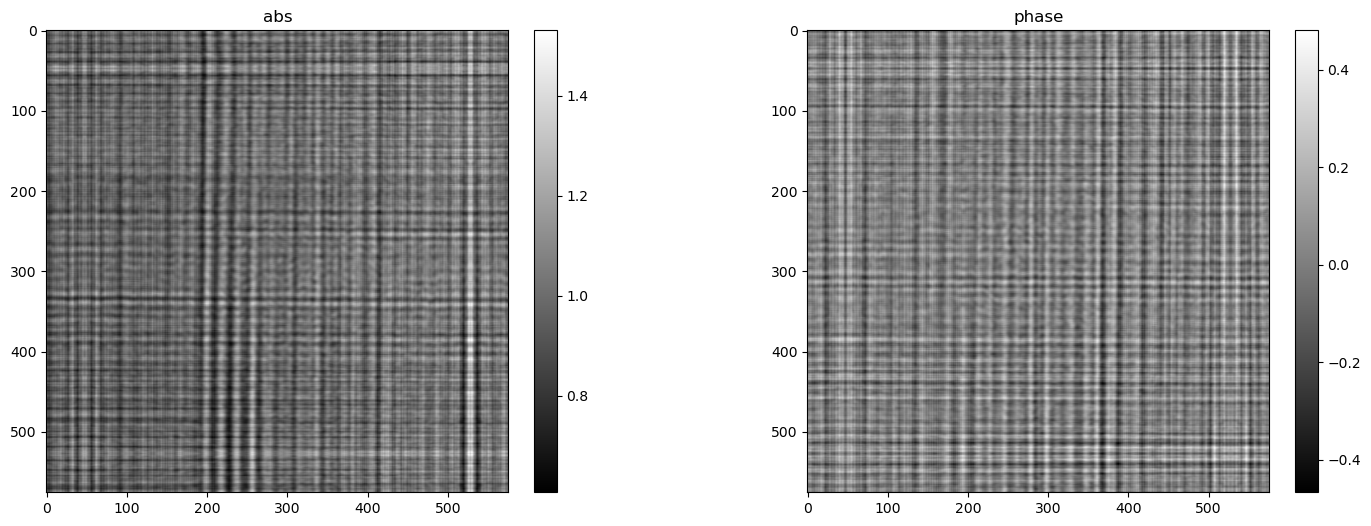

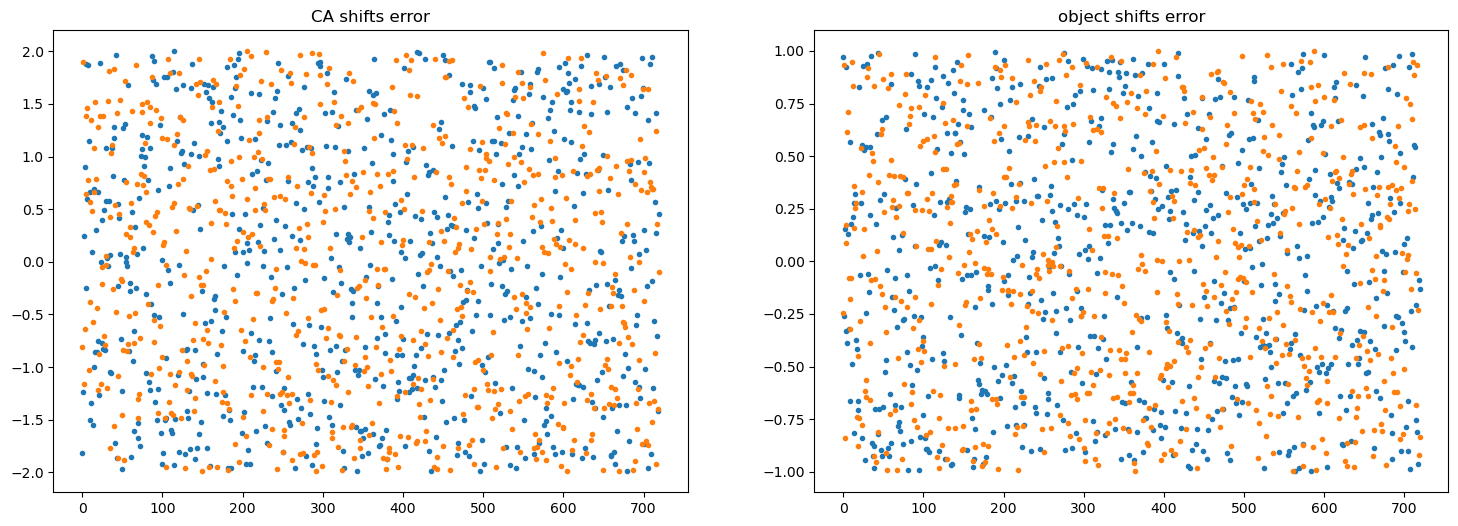

8) err=1.03931e+04


In [ ]:
vars = {}
vars["code"] = code
vars["u"] = np.zeros([args.npsi,args.npsi,args.npsi],dtype='complex64')
vars["q"] = cp.array(q_init)
vars["ri"] = shifts_code.astype("int32")
vars["r_init"] = shifts_code - vars["ri"].astype("int32")
vars["r"] = vars["r_init"]+2*(2*np.random.random([ntheta,2])-1).astype('float32')
vars["rpsi_init"] = shifts_cor.astype("float32")
vars["rpsi"] = vars["rpsi_init"]+(2*np.random.random([ntheta,2])-1).astype('float32')
vars["Ru"] = cl_rec.Spsi(cl_rec.R(vars['u']),vars["rpsi"])
vars["psi"] = cl_rec.expR(vars['Ru'])
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])

cl_rec.rho = [1,30,10,30]
cl_rec.lam = 0 
cl_rec.vis_step=16
cl_rec.err_step=8
cl_rec.eps=0
cl_rec.niter=257*10
cl_rec.eps = 0
cl_rec.path_out = f"/data/vnikitin/ESRF/ID16A/20240924_rec_ca/rec_atomium_syn/r_{cl_rec.lam}_{cl_rec.pad}"
cl_rec.show = show
# data=np.sqrt((np.random.poisson(data**2*5000)/5000).astype('float32'))
vars = cl_rec.BH(data, vars)
err = vars["table"]["err"]
# %load_ext line_profiler
# %lprun -f cl_rec.BH cl_rec.BH(data, vars)
# plt.plot(err,label=rr)


